In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import itertools
import pickle
from multiprocessing import Pool
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from gensim.models import FastText
from sklearn.ensemble import IsolationForest
from tqdm.notebook import tqdm
from collections import defaultdict, Counter
import pickle

In [ ]:
num_jobs = 24

# Predicting outliers

To detect structural outliers we first generate shape-mers for the ProteinNet proteins and AFDBv490 proteins using the code in `make_shapemers.py` which creates `data/proteinnet_shapemers.txt` and `data/afdb90_shapemers.txt`. 

Then, below, we train a FastText model on the ProteinNet shapemers followed by an IsolationForest model on the FastText sentence vectors. These trained models are used to predict outliers for the AFDBv490 protein shape-mer representations, written to `data/outlier_results/afdb90_outliers.txt`.

In [ ]:
def documents_to_keys_corpus(documents):
    keys_corpus = (line.strip().split("\t") for corpus_file in documents for line in tqdm(open(corpus_file)) if
                   len(line.strip().split("\t")) == 2)
    keys, corpus = itertools.tee(keys_corpus)
    keys = [k[0] for k in keys]
    corpus = (k[1] for k in corpus)
    return keys, corpus


def vectorizer_from_documents(documents, fasttext_model_file, corpus_file, num_jobs=100):
    keys, corpus = documents_to_keys_corpus(documents)
    with open(corpus_file, "w") as f:
        for shapemers in corpus:
            f.write(" ".join(f'{int(s):010b}' for s in shapemers.split()) + "\n")
    vectorizer = FastText(vector_size=1024, window=16, min_count=1, workers=num_jobs)
    vectorizer.build_vocab(corpus_file=corpus_file)
    vectorizer.train(
        corpus_file=corpus_file, epochs=vectorizer.epochs,
        total_examples=vectorizer.corpus_count, total_words=vectorizer.corpus_total_words,
    )
    vectorizer.save(str(fasttext_model_file))

In [ ]:
vectorizer_from_documents(["data/proteinnet_shapemers.txt"], 
                          "data/fasttext.mdl", 
                          "data/fasttext_corpus.txt", num_jobs=num_jobs)

In [ ]:
vectorizer = FastText.load("data/fasttext.mdl", mmap='r').wv
outlier_detector = IsolationForest(n_jobs=num_jobs, n_estimators=1000,
                                   max_features=0.5, contamination=0.1,
                                   verbose=10)

In [ ]:
def get_sentence_vector(document):
    return vectorizer.get_sentence_vector([f'{int(s):010b}' for s in document.split()])

def vectorize(corpus, num_jobs, total):
    with Pool(processes=num_jobs) as pool:
        matrix = list(tqdm(pool.imap(get_sentence_vector,
                                     corpus),
                           total=total))
    return np.array(matrix)

In [ ]:
keys, corpus = documents_to_keys_corpus(["data/proteinnet_shapemers.txt"])
matrix = vectorize(corpus, num_jobs, len(keys))
outlier_detector.fit(matrix)
with open("data/isolation_forest.pkl", "wb") as f:
    pickle.dump(outlier_detector, f)

In [ ]:
output_folder = Path("data/outlier_results")
output_folder.mkdir(exist_ok=True)
keys, corpus = documents_to_keys_corpus([Path("data/afdb90_shapemers.txt")])
print("Vectorizing")
matrix = np.array(
    [vectorizer.get_sentence_vector([f'{int(s):010b}' for s in document.split()]) for document in tqdm(corpus)])
print("Predicting")
scores = outlier_detector.decision_function(matrix)
print("Saving")
with open(output_folder / f"afdb90_outliers.txt", "w") as f:
    for key, score in zip(keys, scores):
        f.write(f"{key}\t{score:.3f}\n")

# Outlier Plots

In [ ]:
import sys
import extract_uniprot
import extract_interpro

MONGO_HOST = "10.1.0.202"
MONGO_PORT = 30077

UNIPROT_DB = extract_uniprot.uniprot_extractor(mongo_host=MONGO_HOST, mongo_port=MONGO_PORT)
INTERPRO_DB = extract_interpro.interpro_db_diggested(mongo_host=MONGO_HOST, mongo_port=MONGO_PORT)


def get_data(uniprot_ids):
    uniprot_ids = [x.split("-")[0] for x in uniprot_ids]
    uniprot_collection = UNIPROT_DB.col.find({'_id': {"$in": uniprot_ids}})
    interpro_collection = INTERPRO_DB.col.find({'_id': {"$in": uniprot_ids}})
    data = {}
    for u_entry in tqdm(uniprot_collection):
        data[u_entry["_id"] + "-F1"] = u_entry["data"]
    for i_entry in tqdm(interpro_collection):
        key = i_entry["_id"] + "-F1"
        if key not in data:
            data[key] = {}
        data[key]["interpro"] = i_entry["data"]
    return data

In [ ]:
data_file = pnd.read_csv("data/data.csv", index_col=0)
to_darkness = dict(zip(data_file["AF2_longest_best70"], data_file["FULL_noDUF"]))
to_length = dict(zip(data_file["AF2_longest_best70"], data_file["AF2_longest_best70_len"]))
to_outlier = {}
with open("data/afdb90_outliers.txt") as f:
    for line in tqdm(f):
        key, score = line.strip().split("\t")
        to_outlier[key] = float(score)
data_file["outlier_score"] = [to_outlier.get(k + "-F1", np.nan) for k in data_file["AF2_longest_best70"]]

In [ ]:
outlier_data = get_data([k for k in to_outlier if to_outlier[k] < 0])

In [ ]:
tonb_proteins = []
for k in outlier_data:
    if "interpro" in outlier_data[k] and any("TonB-dependent receptor-like" in i[0] for i in outlier_data[k]["interpro"]):
        tonb_proteins.append(k)

In [12]:
outlier_color = "#67A6D6"
inlier_color = "#E19D25"
background_color = '#F2F2F2'
purple = '#57257F'
inlier_threshold = 0.115

In [ ]:
to_diversity = {}
with open("data/afdb90_shapemers.txt") as f:
    for line in tqdm(f):
        key, shapemers = line.strip().split("\t")
        shapemers = list(map(int, shapemers.split()))
        to_diversity[key] = len(set(shapemers)) / len(shapemers)

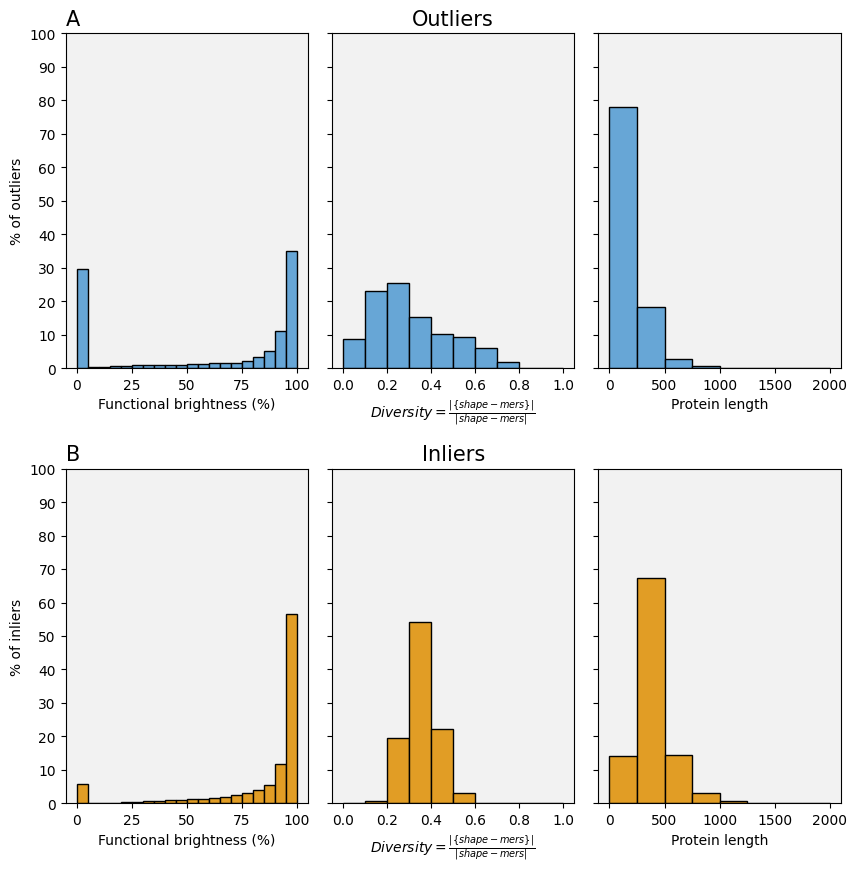

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10), sharey=True)
for i in range(2):
    for j in range(3):
        ax[i][j].set_facecolor(background_color)
        
nbins = np.arange(0, 105, 5)
n = list(range(0,21,5))
l = list(range(0,101,25))
heights, _ = np.histogram([to_darkness[k[:-3]] for k in to_outlier if to_outlier[k] < 0], bins = nbins)
heights = heights * 100/sum(heights)
x = list(range(len(heights)))
y = list(heights)
ax[0][0].bar(x, y, 1, align="edge", 
         label="Outliers", color=outlier_color, edgecolor="black");
ax[0][0].set_xlabel("Functional brightness (%)")
ax[0][0].set_xticks(n, l)

heights, _ = np.histogram([to_darkness[k[:-3]] for k in to_outlier if to_outlier[k] > inlier_threshold], bins = nbins)
heights = heights * 100/sum(heights)
x = list(range(len(heights)))
y = list(heights)
ax[1][0].bar(x, y, 1, align="edge", 
         label="Inliers", color=inlier_color, edgecolor="black");
ax[1][0].set_xlabel("Functional brightness (%)")
ax[1][0].set_xticks(n, l)


nbins = np.arange(0, 1.1, 0.1)
n = [(i, f"{nbins[i]:.1f}") for i in range(len(nbins)) if i%2==0]
heights, _ = np.histogram([to_diversity[k[:-3]] for k in to_outlier if to_outlier[k] < 0], bins = nbins)
heights = heights * 100/sum(heights)
x = list(range(len(heights)))
y = list(heights)
ax[0][1].bar(x, y, 1, align="edge", 
         label="Outliers", color=outlier_color, edgecolor="black");
ax[0][1].set_xlabel("$Diversity=\\frac{|\{shape-mers\}|}{|shape-mers|}$")
ax[0][1].set_xticks([x[0] for x in n], [x[1] for x in n])

heights, _ = np.histogram([to_diversity[k[:-3]] for k in to_outlier if to_outlier[k] > inlier_threshold], bins = nbins)
heights = heights * 100/sum(heights)
x = list(range(len(heights)))
y = list(heights)
ax[1][1].bar(x, y, 1, align="edge", 
         label="Inliers", color=inlier_color, edgecolor="black");
ax[1][1].set_xlabel("$Diversity=\\frac{|\{shape-mers\}|}{|shape-mers|}$")
ax[1][1].set_xticks([x[0] for x in n], [x[1] for x in n])

ax[0][0].set_title("A", fontsize=15, loc="left")
ax[0][1].set_title("Outliers", fontsize=15)
ax[1][0].set_title("B", fontsize=15, loc="left")
ax[1][1].set_title("Inliers", fontsize=15)

nbins = np.arange(0, 2250, 250)
n = [(i, nbins[i]) for i in range(len(nbins)) if i%2==0]
heights, _ = np.histogram([to_length[k[:-3]] for k in to_outlier if to_outlier[k] < 0], bins = nbins)
heights = heights * 100/sum(heights)
x = list(range(len(heights)))
y = list(heights)
ax[0][2].bar(x, y, 1, align="edge", 
         label="Outliers", color=outlier_color, edgecolor="black");
ax[0][2].set_xlabel("Protein length")
ax[0][2].set_xticks([x[0] for x in n], [x[1] for x in n])

heights, _ = np.histogram([to_length[k[:-3]] for k in to_outlier if to_outlier[k] > inlier_threshold], bins = nbins)
heights = heights * 100/sum(heights)
x = list(range(len(heights)))
y = list(heights)
ax[1][2].bar(x, y, 1, align="edge", 
         label="Inliers", color=inlier_color, edgecolor="black");
ax[1][2].set_xlabel("Protein length")
ax[1][2].set_xticks([x[0] for x in n], [x[1] for x in n])

ax[0][0].set_ylabel("% of outliers")
ax[1][0].set_ylabel("% of inliers")
plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.yticks(np.arange(0, 110, 10))
plt.savefig("outliers.pdf", dpi=2000)

In [25]:
counts = data_file[(data_file["outlier_score"].notna())].groupby("subgraphID")["outlier_score"].count().to_dict()
outlier_counts = data_file[(data_file["outlier_score"].notna()) & (data_file["outlier_score"] < 0)].groupby("subgraphID")["outlier_score"].count().to_dict()
component_file = pnd.read_csv("data_generated_v2/AFDB90v4_subgraphs_summary.csv")
darkness_class = []
for _, x in component_file.iterrows():
    if x["Avg_darkness"] <= 5:
        darkness_class.append("fully dark")
    elif x["Avg_darkness"] >= 95:
        darkness_class.append("fully bright")
    else:
        darkness_class.append("none")
component_file["Darkness class"] = darkness_class
component_file["Num outliers"] = [outlier_counts.get(float(x), 0) for x in component_file["Subgraph"]]
component_file["Outlier content"] = [100 * outlier_counts.get(float(x), 0) / counts.get(float(x), 1) for x in component_file["Subgraph"]]
component_file = component_file.set_index('Subgraph')

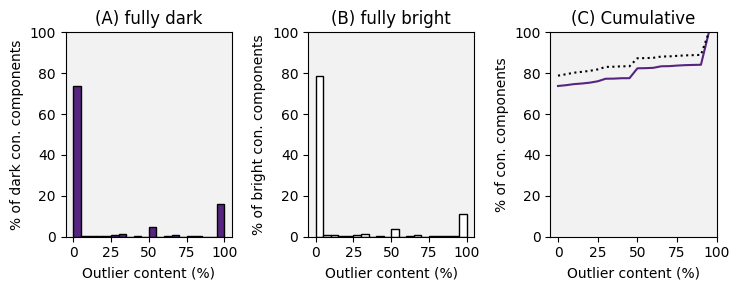

In [26]:
level = 'Outlier content'
modes = ['fully dark', 'fully bright']
panel = ['A', 'B', 'C', 'D', 'E', 'F']

fig, ax = plt.subplots(1, len(modes)+1, figsize=(2.5*(len(modes)+1), 3))
percentage_dufs = []

count = 0
cumulative = {i: [] for i in modes}

for j, mode in enumerate(modes): 
    tmp = component_file.loc[component_file['Darkness class'] == mode]

    h,_ = np.histogram(tmp[level], bins=[i for i in range(0, 105, 5)])
    n_dark = h[0]
    h = h*100/sum(h)

    if mode == 'fully dark':
        colors = ['#57257F' for i in range(len(h))]
    else:
        colors = ['white' for i in range(len(h))]

    x = list(range(len(h)))
    y = list(h)

    ax[j].bar(x,y,1, align='edge', color=colors, edgecolor='k')
    ax[j].set_facecolor('#F2F2F2')
    ax[j].set_xticks(range(0,21,5))
    ax[j].set_xticklabels(range(0,101,25))
    ax[j].set_ylabel('% of {} con. components'.format(mode.split(' ')[1]))
    ax[j].set_xlabel('{} (%)'.format(level))
    ax[j].title.set_text('({}) {}'.format(panel[count], mode))
    ax[j].set_ylim(0,100)
    
    cumulative[mode] = np.cumsum(h)
    count += 1
    if mode == 'fully dark':
        color = '#57257F'
        linestyle = '-'
    else:
        color = 'black'
        linestyle = ':'
    ax[-1].plot(x, cumulative[mode], color=color, linestyle=linestyle)
    ax[-1].set_facecolor('#F2F2F2')
    ax[-1].set_xticks(range(0,21,5))
    ax[-1].set_xticklabels(range(0,101,25))
    ax[-1].set_ylabel('% of con. components')
    ax[-1].set_xlabel('{} (%)'.format(level))
    ax[-1].title.set_text('({}) Cumulative'.format(panel[count]))
    ax[-1].set_ylim(0,100)
        
plt.tight_layout()
plt.savefig('AFDBv4_uniref50_histogram_components_outlier_content.pdf')
plt.savefig('AFDBv4_uniref50_histogram_components_outlier_content.png', dpi=2000)

In [24]:
from scipy.stats import ks_2samp
fully_dark = set(component_file[component_file["Darkness class"] == "fully dark"].index)
fully_bright = set(component_file[component_file["Darkness class"] == "fully bright"].index)
dark_vals = [outlier_counts.get(x, 0) / counts[x] for x in counts if int(x) in fully_dark]
bright_vals = [outlier_counts.get(x, 0) / counts[x] for x in counts if int(x) in fully_bright]
ks_2samp(bright_vals, dark_vals)

KstestResult(statistic=0.05859253572802048, pvalue=5.245038598808748e-81, statistic_location=0.4230769230769231, statistic_sign=1)